In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01m


In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import gymnasium as gym

In [2]:
# Agent
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from collections import deque

class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.tau = 0.01
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.leaning_rate = 0.001
        self.model = self.build_model()
        self.target_model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim = self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse',optimizer='adam')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def replay(self):
        minibatch = self.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                predicted_action = np.argmax(self.model.predict(next_state,verbose=0)[0])
                target = reward + self.gamma * self.target_model.predict(next_state, verbose=0)[0][predicted_action]
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state,target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1- self.tau)
        self.target_model.set_weights(target_weights)

    def save(self, file):
        self.model.save_weights(file)

    def load(self, file):
        self.model.load_weights(file)
            

2023-12-09 18:49:51.469646: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 18:49:51.514216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 18:49:51.514853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 18:49:52.174266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# Train
env = gym.make("Blackjack-v1", sab=True)
state_size_, action_size_ = 3, 2
dqn_agent = DDQNAgent(state_size_, action_size_)
try:
    dqn_agent.load('model.h5')
except:
    print("No previous model detected")
n_episodes = 15000
n_steps = 10
stand, hit = 0, 0
bj_win = 0
bj_games = 0
money = 0
capacity = 10000
cur_money = money
total_step = 0
mon = []

for episode in tqdm(range(n_episodes)):
    bj_games += 1
    cur_state_, _ = env.reset()
    for step in range(n_steps):
        total_step += 1
        cur_state_ = np.reshape(cur_state_, [1, state_size_])
        action = dqn_agent.act(cur_state_)
        if action == 0:
            stand += 1
        else:
            hit += 1
        observation, reward, done, _, _ = env.step(action)
        observation = np.reshape(observation, [1, state_size_])
        dqn_agent.remember(cur_state_, action, reward, observation, done)
        if total_step % dqn_agent.batch_size == 0:
            dqn_agent.replay()
            dqn_agent.update_target_model()
        cur_state_ = observation
        if done:
            if reward > 0:
                bj_win += 1
            money += reward
            break
    if episode % 100 == 0:
        money_change = money - cur_money
        mon.append(money_change)
        dqn_agent.save("model.h5")
        print(f"Stands: {stand}, hits: {hit}, win: {bj_win/bj_games}")
        stand = 0
        hit = 0
        bj_win = 0
        bj_games = 0
        cur_money = money

  0%|                                                                                                                                                              | 0/15000 [00:00<?, ?it/s]

Stands: 0, hits: 1, win: 0.0


  1%|▉                                                                                                                                                   | 100/15000 [00:11<28:27,  8.72it/s]

Stands: 72, hits: 56, win: 0.3


  1%|█▉                                                                                                                                                  | 191/15000 [00:22<29:46,  8.29it/s]

Stands: 70, hits: 69, win: 0.41


  2%|███                                                                                                                                                 | 314/15000 [00:34<22:59, 10.65it/s]

Stands: 68, hits: 74, win: 0.3


  3%|███▊                                                                                                                                                | 383/15000 [00:45<30:39,  7.95it/s]

Stands: 73, hits: 55, win: 0.28


  4%|█████▏                                                                                                                                              | 526/15000 [00:57<20:28, 11.78it/s]

Stands: 68, hits: 59, win: 0.34


  4%|██████▏                                                                                                                                             | 624/15000 [01:08<21:03, 11.38it/s]

Stands: 72, hits: 61, win: 0.34


  5%|██████▉                                                                                                                                             | 708/15000 [01:20<25:31,  9.33it/s]

Stands: 78, hits: 53, win: 0.33


  5%|███████▉                                                                                                                                            | 801/15000 [01:31<22:40, 10.43it/s]

Stands: 59, hits: 77, win: 0.26


  6%|████████▌                                                                                                                                           | 871/15000 [01:42<35:15,  6.68it/s]

Stands: 75, hits: 64, win: 0.25


  7%|█████████▋                                                                                                                                          | 988/15000 [01:54<23:45,  9.83it/s]

Stands: 71, hits: 61, win: 0.27


  8%|███████████                                                                                                                                        | 1127/15000 [02:12<21:06, 10.95it/s]

Stands: 69, hits: 77, win: 0.29


  8%|███████████▋                                                                                                                                       | 1194/15000 [02:25<38:33,  5.97it/s]

Stands: 74, hits: 60, win: 0.34


  9%|████████████▉                                                                                                                                      | 1315/15000 [02:38<21:15, 10.73it/s]

Stands: 72, hits: 62, win: 0.32


  9%|█████████████▊                                                                                                                                     | 1412/15000 [02:54<25:28,  8.89it/s]

Stands: 72, hits: 64, win: 0.33


 10%|██████████████▉                                                                                                                                    | 1522/15000 [03:08<16:42, 13.44it/s]

Stands: 78, hits: 56, win: 0.38


 11%|███████████████▊                                                                                                                                   | 1609/15000 [03:21<20:05, 11.11it/s]

Stands: 77, hits: 49, win: 0.34


 11%|████████████████▋                                                                                                                                  | 1698/15000 [03:37<31:36,  7.01it/s]

Stands: 65, hits: 67, win: 0.26


 12%|█████████████████▋                                                                                                                                 | 1806/15000 [03:54<23:47,  9.24it/s]

Stands: 77, hits: 55, win: 0.33


 13%|██████████████████▊                                                                                                                                | 1919/15000 [04:09<14:19, 15.22it/s]

Stands: 76, hits: 50, win: 0.27


 13%|███████████████████▋                                                                                                                               | 2012/15000 [04:23<17:01, 12.72it/s]

Stands: 81, hits: 49, win: 0.31


 14%|████████████████████▌                                                                                                                              | 2102/15000 [04:39<20:50, 10.31it/s]

Stands: 69, hits: 64, win: 0.29


 15%|█████████████████████▌                                                                                                                             | 2206/15000 [04:56<18:51, 11.31it/s]

Stands: 76, hits: 56, win: 0.26


 15%|██████████████████████▍                                                                                                                            | 2294/15000 [05:10<20:27, 10.35it/s]

Stands: 84, hits: 49, win: 0.36


 16%|███████████████████████▎                                                                                                                           | 2385/15000 [05:24<23:55,  8.79it/s]

Stands: 84, hits: 48, win: 0.3


 17%|████████████████████████▌                                                                                                                          | 2510/15000 [05:45<35:21,  5.89it/s]

Stands: 81, hits: 56, win: 0.37


 17%|█████████████████████████▍                                                                                                                         | 2598/15000 [05:52<10:52, 19.01it/s]

Stands: 78, hits: 43, win: 0.3


 18%|██████████████████████████▍                                                                                                                        | 2695/15000 [06:07<18:30, 11.08it/s]

Stands: 75, hits: 52, win: 0.29


 19%|███████████████████████████▍                                                                                                                       | 2800/15000 [06:21<11:30, 17.66it/s]

Stands: 77, hits: 46, win: 0.28


 19%|████████████████████████████▍                                                                                                                      | 2903/15000 [06:33<14:52, 13.56it/s]

Stands: 82, hits: 37, win: 0.4


 20%|█████████████████████████████▍                                                                                                                     | 3006/15000 [06:47<10:29, 19.06it/s]

Stands: 86, hits: 45, win: 0.33


 21%|██████████████████████████████▍                                                                                                                    | 3110/15000 [07:01<09:25, 21.01it/s]

Stands: 73, hits: 49, win: 0.26


 21%|███████████████████████████████▍                                                                                                                   | 3206/15000 [07:14<16:20, 12.02it/s]

Stands: 75, hits: 56, win: 0.36


 22%|████████████████████████████████▌                                                                                                                  | 3317/15000 [07:28<07:41, 25.32it/s]

Stands: 82, hits: 43, win: 0.34


 23%|█████████████████████████████████▍                                                                                                                 | 3416/15000 [07:43<13:22, 14.43it/s]

Stands: 84, hits: 34, win: 0.25


 23%|██████████████████████████████████▍                                                                                                                | 3510/15000 [07:56<14:08, 13.54it/s]

Stands: 82, hits: 44, win: 0.41


 24%|███████████████████████████████████▎                                                                                                               | 3607/15000 [08:09<17:15, 11.00it/s]

Stands: 84, hits: 40, win: 0.32


 25%|████████████████████████████████████▎                                                                                                              | 3705/15000 [08:22<23:11,  8.12it/s]

Stands: 79, hits: 49, win: 0.35


 25%|█████████████████████████████████████▍                                                                                                             | 3815/15000 [08:36<10:39, 17.48it/s]

Stands: 76, hits: 53, win: 0.31


 26%|██████████████████████████████████████▎                                                                                                            | 3905/15000 [08:49<25:10,  7.34it/s]

Stands: 84, hits: 36, win: 0.36


 27%|███████████████████████████████████████▎                                                                                                           | 4009/15000 [09:03<23:19,  7.85it/s]

Stands: 83, hits: 45, win: 0.29


 27%|████████████████████████████████████████▎                                                                                                          | 4111/15000 [09:18<22:21,  8.12it/s]

Stands: 81, hits: 49, win: 0.34


 28%|█████████████████████████████████████████▏                                                                                                         | 4206/15000 [09:32<30:50,  5.83it/s]

Stands: 76, hits: 44, win: 0.31


 29%|██████████████████████████████████████████▏                                                                                                        | 4305/15000 [09:46<32:26,  5.49it/s]

Stands: 83, hits: 37, win: 0.31


 29%|███████████████████████████████████████████▏                                                                                                       | 4407/15000 [10:00<34:12,  5.16it/s]

Stands: 91, hits: 36, win: 0.32


 30%|████████████████████████████████████████████                                                                                                       | 4498/15000 [10:08<06:10, 28.33it/s]

Stands: 79, hits: 39, win: 0.3


 31%|█████████████████████████████████████████████▏                                                                                                     | 4606/15000 [10:22<06:40, 25.95it/s]

Stands: 84, hits: 36, win: 0.27


 31%|██████████████████████████████████████████████                                                                                                     | 4704/15000 [10:36<10:25, 16.46it/s]

Stands: 87, hits: 34, win: 0.43


 32%|███████████████████████████████████████████████                                                                                                    | 4803/15000 [10:51<11:14, 15.13it/s]

Stands: 79, hits: 55, win: 0.33


 33%|████████████████████████████████████████████████                                                                                                   | 4909/15000 [11:04<07:21, 22.88it/s]

Stands: 77, hits: 47, win: 0.28


 33%|█████████████████████████████████████████████████                                                                                                  | 5007/15000 [11:17<10:48, 15.41it/s]

Stands: 84, hits: 35, win: 0.31


 34%|██████████████████████████████████████████████████                                                                                                 | 5104/15000 [11:31<14:02, 11.75it/s]

Stands: 86, hits: 36, win: 0.33


 35%|███████████████████████████████████████████████████                                                                                                | 5208/15000 [11:44<15:10, 10.76it/s]

Stands: 84, hits: 32, win: 0.33


 35%|████████████████████████████████████████████████████                                                                                               | 5314/15000 [11:57<19:59,  8.07it/s]

Stands: 82, hits: 31, win: 0.23


 36%|████████████████████████████████████████████████████▍                                                                                              | 5349/15000 [12:03<21:45,  7.39it/s]


KeyboardInterrupt: 

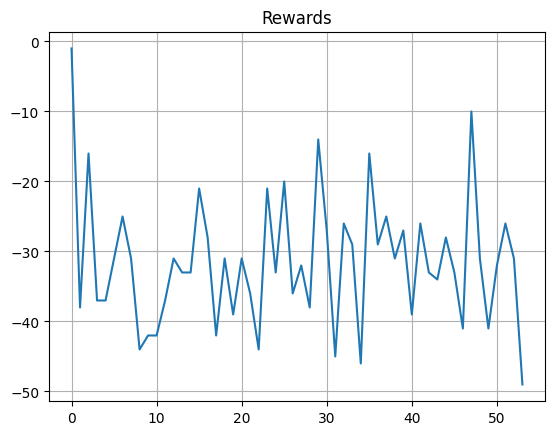

-1722.0
11


In [7]:
# ax = np.linspace(0, n_episodes,num = n_episodes//150)
plt.plot(mon)
plt.title('Rewards',fontsize=12)
plt.grid()
plt.show()
print(money)
print(bj_win)